# Analyzing NYC High School Data
This project is going to be taking different files about high schools in the NY state and assessing some simple analysis on SAT scores.
<br>
The Data is stored in: [Here](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)

# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as plt

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("/Users/hokyoon/Desktop/Data_Science/Data_Sets/NYC_High_School_Data/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("/Users/hokyoon/Desktop/Data_Science/Data_Sets/NYC_High_School_Data/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("/Users/hokyoon/Desktop/Data_Science/Data_Sets/NYC_High_School_Data/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort = True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

## Data dictonary for survey_fields

rr_s&emsp;&emsp;Student Response Rate<br>
rr_t&emsp;&emsp;Teacher Response Rate<br>
rr_p&emsp;&emsp;Parent Response Rate<br>
N_s&emsp;&emsp;Number of student respondents<br>
N_t&emsp;&emsp;Number of teacher respondents<br>
N_p&emsp;&emsp;Number of parent respondents<br>
nr_s&emsp;&emsp;Number of eligible students<br>
nr_t&emsp;&emsp;Number of eligible teachers<br>
nr_p&emsp;&emsp;Number of eligible parents<br>
saf_p_11&emsp;&emsp;Safety and Respect score based on parent responses<br>
com_p_11&emsp;&emsp;Communication score based on parent responses<br>
eng_p_11&emsp;&emsp;Engagement score based on parent responses<br>
aca_p_11&emsp;&emsp;Academic expectations score based on parent responses<br>
saf_t_11&emsp;&emsp;Safety and Respect score based on teacher responses<br>
com_t_11&emsp;&emsp;Communication score based on teacher responses<br>
eng_t_11&emsp;&emsp;Engagement score based on teacher responses<br>
aca_t_11&emsp;&emsp;Academic expectations score based on teacher responses<br>
saf_s_11&emsp;&emsp;Safety and Respect score based on student responses<br>
com_s_11&emsp;&emsp;Communication score based on student responses<br>
eng_s_11&emsp;&emsp;Engagement score based on student responses<br>
aca_s_11&emsp;&emsp;Academic expectations score based on student responses<br>
saf_tot_11&emsp;&emsp;Safety and Respect total score<br>
com_tot_11&emsp;&emsp;Communication total score<br>
eng_tot_11&emsp;&emsp;Engagement total score<br>
aca_tot_11&emsp;&emsp;Academic Expectations total score

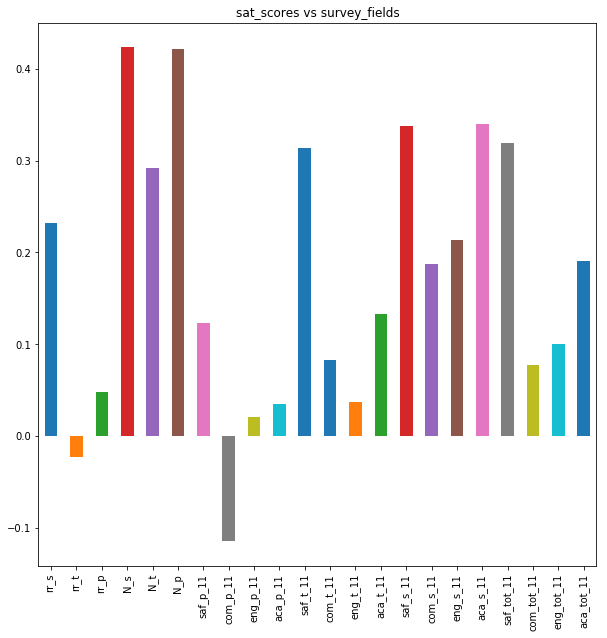

In [12]:
correlations[survey_fields].plot(
    kind = 'bar'
    , figsize = (10,10)
    , title = 'sat_scores vs survey_fields'
    , legend = False
    )



We can see N_s, N_t, N_p, saf_t_11, saf_s_11, aca_s_11, saf_tot_11 all have a correlation above .25, which we deem interesting. <br><br>

Looking back at the data dictonary, these values mean that:<br><br>

N_s  Number of student respondents<br>
N_t  Number of teacher respondents<br>
N_p  Number of parent respondents<br>
saf_t_11  Safety and Respect score based on teacher responses<br>
saf_s_11  Safety and Respect score based on student responses<br>
aca_s_11  Academic expectations score based on student responses<br>
saf_tot_11  Safety and Respect total score<br><br>

have positive correlation to Sat_scores<br>
<br>

We will dig into saf_t_11 and saf_s_11 deeper


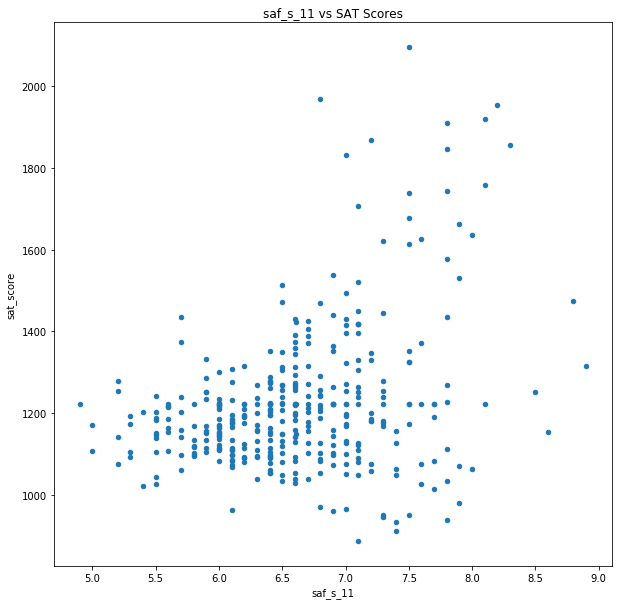

In [13]:
combined.plot(x='saf_s_11'
              , y='sat_score'
              , kind = 'scatter'
              , figsize = (10,10)
              , title= 'saf_s_11 vs SAT Scores')

It looks like most of the lower sat scores are bunched up with the lower saf_s_11 scores, slowly trending up together

In [14]:
safety_score_by_dist = combined.groupby('school_dist').agg(np.mean) #get the avg saftey score per school district
safety_score_by_dist.reset_index(inplace = True)

cols = ['school_dist','saf_s_11', 'lat','lon']
safety_score_by_dist[cols]

,school_dist,saf_s_11,lat,lon
0,01,6.768611,40.719022,-73.982377
1,02,6.910660,40.739699,-73.991386
2,03,6.716667,40.781574,-73.977370
3,04,6.885714,40.793449,-73.943215
4,05,6.314286,40.817077,-73.949251
5,06,6.950000,40.848970,-73.932502
6,07,6.800000,40.816815,-73.919971
7,08,6.364697,40.823803,-73.866087
8,09,6.655000,40.836349,-73.906240
9,10,6.577273,40.870345,-73.898360


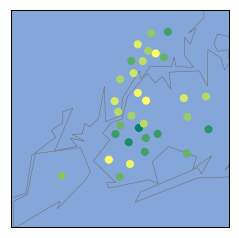

In [15]:
import os
os.environ['PROJ_LIB'] = r'/anaconda3/pkgs/proj4-5.2.0-h0a44026_1/share/proj'


from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = safety_score_by_dist['lon'].tolist()
latitudes = safety_score_by_dist['lat'].tolist()

m.scatter(x=longitudes,y=latitudes,s=50,zorder=2,latlon=True,c=safety_score_by_dist['saf_s_11'], cmap = 'summer')


The map above shows each school district in their respective borough. the more the dot has a yellow color, the more of a lower saftey score it has. The greener the higher. <br><br>

Next, we will see if each racial group has any correlation with sat_scores

Text(0,0.5,'SAT Score')

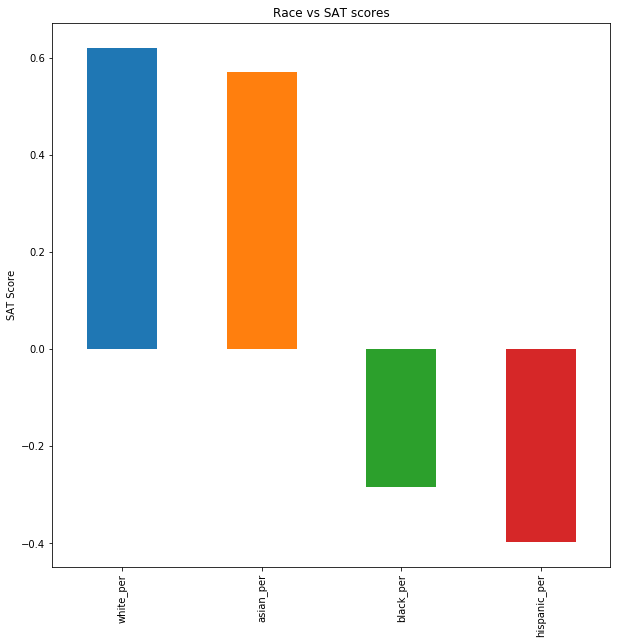

In [16]:
cols = ['white_per','asian_per','black_per','hispanic_per']

ax = correlations[cols].plot(kind='bar', figsize = (10,10), title = 'Race vs SAT scores')
ax.set_ylabel('SAT Score')

Seems like hispanic_per has a negative correlation.<br><br>

Let's dig deeper into this

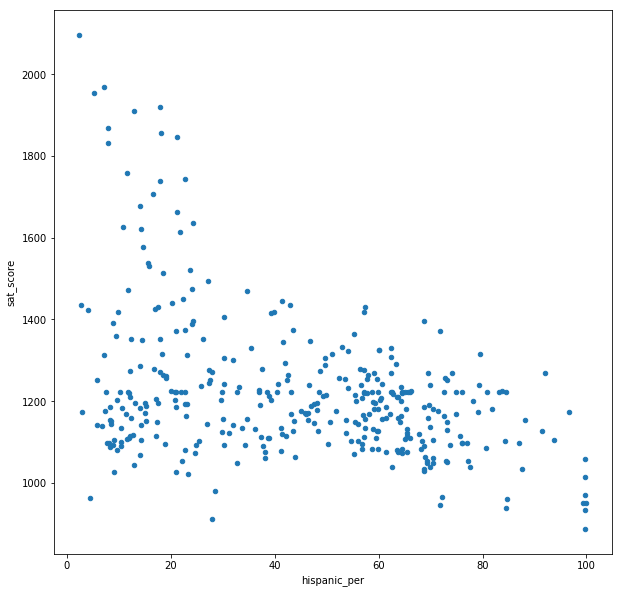

In [20]:
combined.plot(x='hispanic_per', y='sat_score',kind='scatter',figsize = (10,10))

This seems like where the schools with 100% hispanic students have a very low SAT score while when we go further to the left(lower hispanic_per), we see that the SAT score increase<br>
<br>
Let's look at all the schools with a hispanic_per > 95%

In [23]:
combined[combined['hispanic_per']>95]['SCHOOL NAME'].values

array(['MANHATTAN BRIDGES HIGH SCHOOL',
       'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL',
       'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS',
       'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
       'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE',
       'MULTICULTURAL HIGH SCHOOL',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL'], dtype=object)

With a quick Google search, it looks like most of these schools are in the Bronx with a few in Manhatten

<br>
<br>
Let's now look at the dataset with hispanic_per < 10% and an average SAT score > than 1800

In [24]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME'].values

array(['STUYVESANT HIGH SCHOOL', 'BRONX HIGH SCHOOL OF SCIENCE',
       'BROOKLYN TECHNICAL HIGH SCHOOL',
       'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE',
       'STATEN ISLAND TECHNICAL HIGH SCHOOL'], dtype=object)

With the exception of one school in the Bronx, it looks like every other school is distributed throughout the boroughs

Let's do the same analysis with male_per and female_per

Text(0,0.5,'SAT Score')

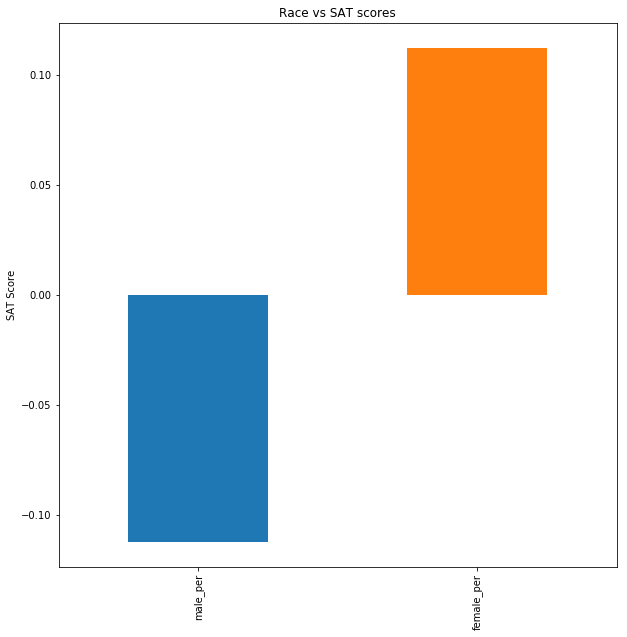

In [25]:
cols = ['male_per','female_per']

ax = correlations[cols].plot(kind='bar', figsize = (10,10), title = 'Race vs SAT scores')
ax.set_ylabel('SAT Score')

Looks like the male_per and female_per correlations are opposite!

However, we can see that the corrleation is pretty weak

Again, let's create a scatter plot for the positive correlating column: female_per

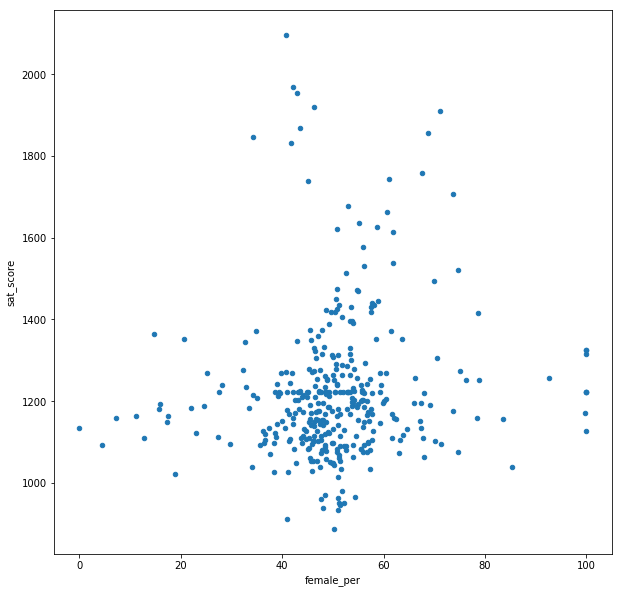

In [26]:
combined.plot(x='female_per', y='sat_score', kind='scatter', figsize = (10,10))

We can see that when female percentage is around 50%, there are a lot of mixed results. This shows that the correlation isn't really there due to all the spread
<br><br>
Let's look at schools that have female_per > 60% and SAT score > 1700

In [27]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME'].values

array(['BARD HIGH SCHOOL EARLY COLLEGE', 'ELEANOR ROOSEVELT HIGH SCHOOL',
       'BEACON HIGH SCHOOL',
       'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
       'TOWNSEND HARRIS HIGH SCHOOL'], dtype=object)

Again, with another quick Google search, we can see that these schools are in Manhatten or Queens
<br><br>
Next, let's do an analysis on high schools that took AP courses as it correlates with SAT scores.
- We'll first calculate a new column: ap_per which takes the number of AP courses divided by total enrollment
- Then we will create a scatter plot between the ap_per and SAT scores

Text(0,0.5,'SAT Score')

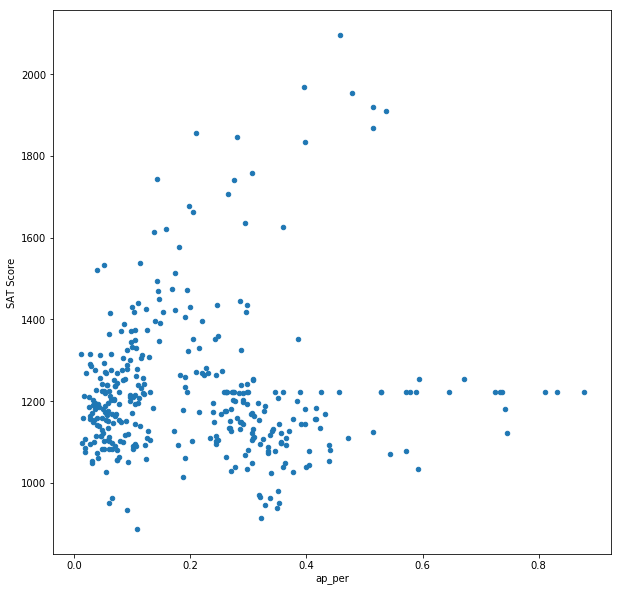

In [31]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment'] # create new column

ax = combined.plot(x='ap_per',y='sat_score',figsize=(10,10), kind = 'scatter')
ax.set_ylabel('SAT Score')

Doesn't seem like there is much of a correlation.

To make sure, let's calculate it.

In [33]:
correlations = combined.corr()
correlations.loc['ap_per','sat_score']

0.05717081390766967

Just as expected, there is not much of a correlation.